In [2]:
import optuna
import pandas as pd
import numpy as np
import datamol as dm
from molfeat.trans.fp import FPVecTransformer # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

/home/sladem/miniconda3/envs/datamol/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#If SMILES data
#from molfeat.trans.fp import FPVecTransformer # type: ignore
#fp = FPVecTransformer(kind="ecfp", length=2048, n_jobs=4)  # ECFP with 2048 bits
#X = fp(df["SMILES"].tolist())

In [ ]:
   # X.shape = (N, 2048)
# y = df["target"].values
df = pd.read_csv("Konda_pIC50_train.csv")
X = df.drop(columns=["COMPOUND_ID", "target"])
y = df["target"].values

In [6]:
def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use 5-fold CV to evaluate performance
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
    
    # Optuna tries to minimize the objective, so return the mean MSE
    return np.mean(scores)


In [8]:
#study = optuna.create_study(direction="maximize")  # because higher neg-MSE = better (lower MSE)
#study.optimize(objective, n_trials=50)

trial_cnt=3

import time
import optuna

def timed_optuna_study(objective, n_trials=50, direction="maximize"):
    start = time.time()
    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials)
    duration = time.time() - start

    study.set_user_attr("runtime_sec", duration)
    print(f"Study took {duration/60:.2f} minutes")
    return study, duration

# Usage, have to call it like this:
study = timed_optuna_study(objective, n_trials=trial_cnt)



[I 2025-10-12 17:06:39,405] A new study created in memory with name: no-name-b6088113-6d9e-40dd-84f2-492f50de0a92
[I 2025-10-12 17:06:57,608] Trial 0 finished with value: -0.7495009932348691 and parameters: {'n_estimators': 344, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: -0.7495009932348691.
[I 2025-10-12 17:11:06,735] Trial 1 finished with value: -0.574387285397771 and parameters: {'n_estimators': 185, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: -0.574387285397771.
[I 2025-10-12 17:28:12,961] Trial 2 finished with value: -0.571822668106589 and parameters: {'n_estimators': 787, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 2 with value: -0.571822668106589.


Study took 21.56 minutes


In [14]:
print("Best trial:")
trial = study.best_trial
print(f"  Value (neg MSE): {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


Best trial:
  Value (neg MSE): -0.4533973256497491
  Params:
    n_estimators: 231
    max_depth: 30
    min_samples_split: 5
    min_samples_leaf: 2
    max_features: None


Can use these in new model but replace ":" with "=" sign:

In [ ]:
best_model = RandomForestRegressor(
    n_estimators=231
    max_depth=30
    min_samples_split=5
    min_samples_leaf=2
    max_features=Non
    n_jobs=-1
)
best_model.fit(X, y)

### Now try the model with best params on the holdout test set

In [16]:
df_final = pd.read_csv("Konda_regression_test.csv")
X_holdout = df_final.drop(columns=["COMPOUND_ID", "target"])
y_holdout = df_final["target"]

Holdout R²: 0.586
Holdout RMSE: 0.657


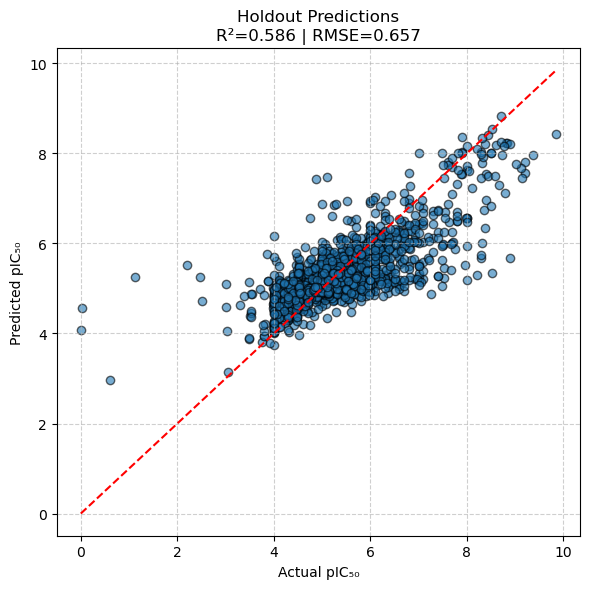

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error
import numpy as np

# Refit best model on all training data (not including holdout)
best_model = RandomForestRegressor(
    **study.best_params,
    random_state=42,
    n_jobs=-1
)
best_model.fit(X, y)

# Evaluate on holdout test set
y_pred = best_model.predict(X_holdout)
r2 = r2_score(y_holdout, y_pred)
rmse = root_mean_squared_error(y_holdout, y_pred)

print(f"Holdout R²: {r2:.3f}")
print(f"Holdout RMSE: {rmse:.3f}")

# ---- Plot predicted vs actual ----
plt.figure(figsize=(6,6))
plt.scatter(y_holdout, y_pred, alpha=0.6, edgecolor='k')
plt.plot([min(y_holdout), max(y_holdout)], [min(y_holdout), max(y_holdout)], 'r--')
plt.title(f"Holdout Predictions\nR²={r2:.3f} | RMSE={rmse:.3f}")
plt.xlabel("Actual pIC₅₀")
plt.ylabel("Predicted pIC₅₀")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def objective_lgb(trial):
    # --- Suggest hyperparameters ---
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1e-1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1e-1, log=True),
        "random_state": 42,
        "n_jobs": -1,
    }

    # --- Train/validation split for this trial ---
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # --- Train the model ---
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        early_stopping_rounds=50,
        verbose=False
    )

    # --- Evaluate on validation set ---
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    return r2


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_lgb, n_trials=50)

print("Best R²:", study.best_value)
print("Best Parameters:", study.best_trial.params)


In [ ]:
print("Best trial:")
trial = study.best_trial
print(f"  Value (neg MSE): {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


In [ ]:
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_holdout)
r2 = r2_score(y_holdout, y_pred)
rmse = root_mean_squared_error(y_holdout, y_pred)

print(f"Holdout R²: {r2:.3f}")
print(f"Holdout RMSE: {rmse:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_holdout, y_pred, alpha=0.6, edgecolor="k")
plt.plot([min(y_holdout), max(y_holdout)], [min(y_holdout), max(y_holdout)], "r--")
plt.title(f"LightGBM Holdout Predictions\nR²={r2:.3f} | RMSE={rmse:.3f}")
plt.xlabel("Actual pIC₅₀")
plt.ylabel("Predicted pIC₅₀")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# From optuna tutorial
import optuna
import sklearn.datasets
import sklearn.linear_model
import sklearn.metrics

def objective(trial):
    # hyperparameter setting
    regression_method = trial.suggest_categorical('regression_method', ('ridge', 'lasso'))
    if regression_method == 'ridge':
        ridge_alpha = trial.suggest_uniform('ridge_alpha', 0.0, 2.0)
        model = sklearn.linear_model.Ridge(alpha=ridge_alpha)
    else:
        lasso_alpha = trial.suggest_uniform('lasso_alpha', 0.0, 2.0)
        model = sklearn.linear_model.Lasso(alpha=lasso_alpha)

    # data loading and train-test split
    X, y = sklearn.datasets.load_boston(return_X_y=True)
    X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, random_state=0)

    # model training and evaluation
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    error = sklearn.metrics.mean_squared_error(y_val, y_pred)

    # output: evaluation score
    return error

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

In [ ]:
print('Minimum mean squared error: ' + str(study.best_value))
print('Best parameter: ' + str(study.best_params))

study.trials_dataframe()